# Financial Planning with APIs and Simulations

In this Challenge, you’ll create two financial analysis tools by using a single Jupyter notebook:

Part 1: A financial planner for emergencies. The members will be able to use this tool to visualize their current savings. The members can then determine if they have enough reserves for an emergency fund.

Part 2: A financial planner for retirement. This tool will forecast the performance of their retirement portfolio in 30 years. To do this, the tool will make an Alpaca API call via the Alpaca SDK to get historical price data for use in Monte Carlo simulations.

You’ll use the information from the Monte Carlo simulation to answer questions about the portfolio in your Jupyter notebook.



In [3]:
# Import the required libraries and dependencies
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from utils.mcforcasting import MCSimulation
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# print(np.__version__)
# print(pd.__version__)


In [4]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

#### Enter the total number of shares held.

In [25]:
# # Current amount of shares held in both the stock (SPY) and bond (AGG) portion of the portfolio.
spy_shares = 50
agg_shares = 50
total_crypto_wallet = 2000

In [26]:
# Set the variables for the Alpaca API and secret keys
alpaca_api_key = os.getenv("APCA_API_KEY_ID")
alpaca_secret_key = os.getenv("APCA_SECRET_KEY")
# display(type(alpaca_api_key))
# display(type(alpaca_secret_key))

# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [27]:
# Set the tickers for both the bond and stock portion of the portfolio

tickers = ["SPY", "AGG"]

# Set timeframe to 1Day
timeframe = "1Day"

start_date = pd.Timestamp("2020-08-07", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-08-07", tz="America/New_York").isoformat()

In [28]:
# Use the Alpaca get_bars function to get current closing prices the portfolio
# Be sure to set the `df` property after the function to format the response object as a DataFrame
prices_df = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
SPY = prices_df[prices_df['symbol']=='SPY'].drop('symbol', axis=1)
AGG = prices_df[prices_df['symbol']=='AGG'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
prices_df = pd.concat([SPY, AGG], axis=1, keys=["SPY", "AGG"])

# Review the first 5 rows of the Alpaca DataFrame
prices_df.head()

SPY                                   \
                             open    high    low   close    volume   
timestamp                                                            
2020-08-07 04:00:00+00:00  333.29  334.88  332.3  334.57  57282821   

                                                      AGG                   \
                          trade_count        vwap    open    high      low   
timestamp                                                                    
2020-08-07 04:00:00+00:00      350100  333.800372  119.66  119.73  119.395   

                                                                    
                            close   volume trade_count        vwap  
timestamp                                                           
2020-08-07 04:00:00+00:00  119.43  5559066       15246  119.475306

In [29]:
agg_close_price = float(prices_df['AGG']['close'])
agg_close_price

119.43

In [30]:
spy_close_price = float(prices_df['SPY']['close'])
spy_close_price

334.57

#### Step 6: Calculate the value, in US dollars, of the current amount of shares in each of the stock and bond portions of the portfolio, and print the results.

In [31]:
# Calculate the current value of the bond portion of the portfolio
agg_value = agg_close_price * agg_shares
spy_value = spy_close_price * spy_shares
total_stocks_bonds = agg_value + spy_value
total_portfolio = round(total_stocks_bonds + total_crypto_wallet, 2)

total_portfolio

24700.0

In [32]:
# Consolidate financial assets data into a Python list
savings_data = [total_crypto_wallet, total_stocks_bonds] 

# Review the Python list savings_data
savings_data 

[2000, 22700.0]

In [33]:
# Create a Pandas DataFrame called savings_df 
savings_df = pd.DataFrame(savings_data, columns=['amount'], index=['crypto', 'stock/bond'])
savings_df


,amount
crypto,2000.0
stock/bond,22700.0


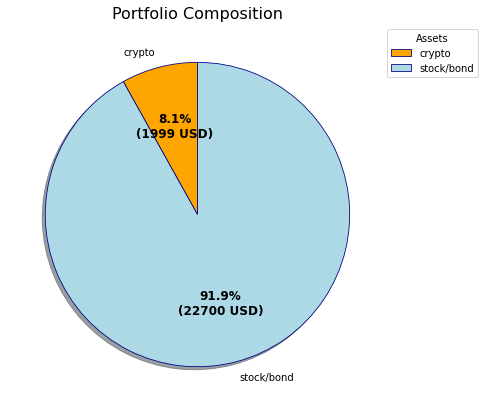

In [34]:
# Plot the total value of the member's portfolio (crypto and stock/bond) in a pie chart

# Creating dataset
assets = savings_df.index.values.tolist()
data = savings_df['amount']

## Creating explode data
explode = (0.0, 0.0)
 
## Creating color parameters
colors = ("orange", "lightblue")
 
## Wedge properties
wp = { 'linewidth' : 0.8, 'edgecolor' : "navy" }
 
## Creating autopct arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} USD)".format(pct, absolute)
 
## Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data,
                                  autopct = lambda pct: func(pct, data),
                                  explode = explode,
                                  labels = assets,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
 
# Adding legend
ax.legend(wedges, assets,
          title ="Assets",
          loc ="upper right",
          bbox_to_anchor =(1, 0, 0.25, 1))
 
plt.setp(autotexts, size = 12, weight ="bold")
ax.set_title("Portfolio Composition", fontsize=16)
 
# show plot
plt.show()


## MC Forcasting

### Create the Monte Carlo Simulation

In this section, you’ll use the MCForecastTools library to create a Monte Carlo simulation for the member’s savings portfolio.

#### Step 1: Make an API call via the Alpaca SDK to get 3 years of historical closing prices for a traditional 60/40 portfolio split: 60% stocks (SPY) and 40% bonds (AGG).

In [35]:
# Set start and end dates of 3 years back from your current date
# Alternatively, you can use an end date of 2020-08-07 and work 3 years back from that date 
start_date = pd.Timestamp("2017-08-07", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-08-07", tz="America/New_York").isoformat()

# Set number of rows to 1000 to retrieve the maximum amount of rows
#row_limit = 1000

In [36]:
# Use the Alpaca get_bars function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame
daily_returns_df = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    # limit=row_limit
).df

# Reorganize the DataFrame
# Separate ticker data
SPY = daily_returns_df[daily_returns_df['symbol']=='SPY'].drop('symbol', axis=1)
AGG = daily_returns_df[daily_returns_df['symbol']=='AGG'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
daily_returns_df = pd.concat([SPY, AGG], axis=1, keys=["SPY", "AGG"]) # .dropna()

# Display both the first and last five rows of the DataFrame
display(daily_returns_df.head(5))
display(daily_returns_df.tail(5))
# len(daily_returns_df)

SPY                                     \
                             open    high     low   close     volume   
timestamp                                                              
2017-08-07 04:00:00+00:00  247.50  247.87  247.37  247.87   31995021   
2017-08-08 04:00:00+00:00  247.49  248.91  246.83  247.26   61719353   
2017-08-09 04:00:00+00:00  246.46  247.31  246.06  247.25   62632619   
2017-08-10 04:00:00+00:00  246.30  246.44  243.70  243.76  120418270   
2017-08-11 04:00:00+00:00  244.00  244.80  243.75  244.12   74869947   

                                                      AGG                    \
                          trade_count        vwap    open    high       low   
timestamp                                                                     
2017-08-07 04:00:00+00:00      100111  247.668698  109.69  109.72  109.6066   
2017-08-08 04:00:00+00:00      192921  247.739709  109.67  109.69  109.5000   
2017-08-09 04:00:00+00:00      223650  246.791421  109.87  109.87  109.6600   
2017-08-10 04:00:00+00:00      424321  245.027847  109.70  109.85  109.6700   
2017-08-11 04:00:00+00:00      278786  244.222867  109.75  109.94  109.6800   

                                                                    
                            close   volume trade_count        vwap  
timestamp                                                           
2017-08-07 04:00:00+00:00  109.67  2359826        7755  109.674876  
2017-08-08 04:00:00+00:00  109.57  2570876       12663  109.577636  
2017-08-09 04:00:00+00:00  109.67  2308932       11031  109.771749  
2017-08-10 04:00:00+00:00  109.78  2004163       12437  109.776611  
2017-08-11 04:00:00+00:00  109.87  1913253       10113  109.860974

SPY                                    \
                             open    high     low   close    volume   
timestamp                                                             
2020-08-03 04:00:00+00:00  328.31  329.62  327.73  328.79  53080454   
2020-08-04 04:00:00+00:00  327.88  330.06  327.86  330.06  41918004   
2020-08-05 04:00:00+00:00  331.46  332.39  331.18  332.11  42870955   
2020-08-06 04:00:00+00:00  331.52  334.46  331.13  334.33  43745653   
2020-08-07 04:00:00+00:00  333.29  334.88  332.30  334.57  57282821   

                                                      AGG                    \
                          trade_count        vwap    open    high       low   
timestamp                                                                     
2020-08-03 04:00:00+00:00      288008  328.658804  119.37  119.40  119.1903   
2020-08-04 04:00:00+00:00      250900  329.057593  119.42  119.63  119.4200   
2020-08-05 04:00:00+00:00      241416  331.791643  119.39  119.49  119.3100   
2020-08-06 04:00:00+00:00      290039  332.937218  119.62  119.73  119.5300   
2020-08-07 04:00:00+00:00      350100  333.800372  119.66  119.73  119.3950   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2020-08-03 04:00:00+00:00  119.40  13014535       36359  119.282420  
2020-08-04 04:00:00+00:00  119.63  10935181       39114  119.541666  
2020-08-05 04:00:00+00:00  119.40  17377874       42313  119.387245  
2020-08-06 04:00:00+00:00  119.57   4608710       15938  119.604199  
2020-08-07 04:00:00+00:00  119.43   5559066       15246  119.475306

#### Step 2: Run a Monte Carlo simulation of 500 samples and 30 years for the 60/40 portfolio, and then plot the results.

In [37]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.
MC_30yr_6040_weight = MCSimulation(
    portfolio_data = daily_returns_df,
    weights = [.6,.4],
    num_simulation = 500,
    num_trading_days = 252*30
)

# Review the simulation input data
MC_30yr_6040_weight.portfolio_data


SPY                                     \
                             open    high     low   close     volume   
timestamp                                                              
2017-08-07 04:00:00+00:00  247.50  247.87  247.37  247.87   31995021   
2017-08-08 04:00:00+00:00  247.49  248.91  246.83  247.26   61719353   
2017-08-09 04:00:00+00:00  246.46  247.31  246.06  247.25   62632619   
2017-08-10 04:00:00+00:00  246.30  246.44  243.70  243.76  120418270   
2017-08-11 04:00:00+00:00  244.00  244.80  243.75  244.12   74869947   
...                           ...     ...     ...     ...        ...   
2020-08-03 04:00:00+00:00  328.31  329.62  327.73  328.79   53080454   
2020-08-04 04:00:00+00:00  327.88  330.06  327.86  330.06   41918004   
2020-08-05 04:00:00+00:00  331.46  332.39  331.18  332.11   42870955   
2020-08-06 04:00:00+00:00  331.52  334.46  331.13  334.33   43745653   
2020-08-07 04:00:00+00:00  333.29  334.88  332.30  334.57   57282821   

                                                                   AGG  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-08-07 04:00:00+00:00      100111  247.668698          NaN  109.69   
2017-08-08 04:00:00+00:00      192921  247.739709    -0.002461  109.67   
2017-08-09 04:00:00+00:00      223650  246.791421    -0.000040  109.87   
2017-08-10 04:00:00+00:00      424321  245.027847    -0.014115  109.70   
2017-08-11 04:00:00+00:00      278786  244.222867     0.001477  109.75   
...                               ...         ...          ...     ...   
2020-08-03 04:00:00+00:00      288008  328.658804     0.006952  119.37   
2020-08-04 04:00:00+00:00      250900  329.057593     0.003863  119.42   
2020-08-05 04:00:00+00:00      241416  331.791643     0.006211  119.39   
2020-08-06 04:00:00+00:00      290039  332.937218     0.006685  119.62   
2020-08-07 04:00:00+00:00      350100  333.800372     0.000718  119.66   

                                                                           \
                             high       low   close    volume trade_count   
timestamp                                                                   
2017-08-07 04:00:00+00:00  109.72  109.6066  109.67   2359826        7755   
2017-08-08 04:00:00+00:00  109.69  109.5000  109.57   2570876       12663   
2017-08-09 04:00:00+00:00  109.87  109.6600  109.67   2308932       11031   
2017-08-10 04:00:00+00:00  109.85  109.6700  109.78   2004163       12437   
2017-08-11 04:00:00+00:00  109.94  109.6800  109.87   1913253       10113   
...                           ...       ...     ...       ...         ...   
2020-08-03 04:00:00+00:00  119.40  119.1903  119.40  13014535       36359   
2020-08-04 04:00:00+00:00  119.63  119.4200  119.63  10935181       39114   
2020-08-05 04:00:00+00:00  119.49  119.3100  119.40  17377874       42313   
2020-08-06 04:00:00+00:00  119.73  119.5300  119.57   4608710       15938   
2020-08-07 04:00:00+00:00  119.73  119.3950  119.43   5559066       15246   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-08-07 04:00:00+00:00  109.674876          NaN  
2017-08-08 04:00:00+00:00  109.577636    -0.000912  
2017-08-09 04:00:00+00:00  109.771749     0.000913  
2017-08-10 04:00:00+00:00  109.776611     0.001003  
2017-08-11 04:00:00+00:00  109.860974     0.000820  
...                               ...          ...  
2020-08-03 04:00:00+00:00  119.282420    -0.001338  
2020-08-04 04:00:00+00:00  119.541666     0.001926  
2020-08-05 04:00:00+00:00  119.387245    -0.001923  
2020-08-06 04:00:00+00:00  119.604199     0.001424  
2020-08-07 04:00:00+00:00  119.475306    -0.001171  

[757 rows x 16 columns]

In [38]:
# Run the Monte Carlo simulation to forecast 30 years cumulative returns
MC_30yr_6040_weight.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/harry/Development/FinTech/Projects/ecocrypto_portfolio_analysis/sandbox/utils/mcforcasting.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.023070,1.009503,0.995292,0.993426,1.009642,1.002348,1.008591,1.007675,0.986766,1.009764,...,1.012212,1.010958,0.993141,0.986325,0.990515,1.004360,1.007368,1.002586,1.000780,1.003496
2,1.039279,1.022693,0.999309,1.013559,0.999284,0.998875,1.017650,1.003533,0.968803,0.992813,...,1.015103,1.001680,1.003540,0.964203,0.993050,1.008026,0.999789,0.999559,1.003603,1.004282
3,1.031178,1.024023,0.997410,0.998460,0.999418,0.985277,1.017980,1.010854,0.977288,0.993250,...,1.016198,1.009877,1.011787,0.977914,0.996299,0.996992,0.989606,0.997793,0.996237,1.011136
4,1.040736,1.027403,1.007833,1.006348,1.003463,0.985840,1.021415,1.018121,0.991020,0.981988,...,1.024299,1.011252,1.000733,0.994735,1.005596,0.996925,0.986717,0.998741,0.986042,1.014079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,26.453642,7.373014,13.450485,1.997360,9.603474,4.745734,7.600818,4.272658,15.892374,5.020335,...,16.810338,3.417744,22.204020,15.376451,2.147165,9.559568,11.327935,4.525263,7.220075,8.224726
7557,26.529007,7.481748,13.633387,1.990676,9.601032,4.739421,7.555624,4.268272,15.960398,5.095052,...,16.861198,3.421246,22.015605,15.484048,2.132214,9.478416,11.516560,4.505618,7.107016,8.174988
7558,26.571705,7.477955,13.676517,1.954859,9.551465,4.682694,7.614634,4.331778,16.236970,5.086176,...,17.022967,3.464035,21.992500,15.422581,2.109643,9.574995,11.664834,4.464038,7.050748,8.130298
7559,26.293180,7.536730,13.750696,1.936512,9.526229,4.666935,7.676525,4.277142,16.147043,5.187297,...,17.057923,3.439687,22.115654,15.194292,2.126158,9.461419,11.601310,4.453173,6.969501,8.090844


In [ ]:
# Visualize the 30-year Monte Carlo simulation by creating an
# overlay line plot
MC_30yr_6040_weight_line_plot = MC_30yr_6040_weight.plot_simulation()

#### Step 3: Plot the probability distribution of the Monte Carlo simulation.

In [ ]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
MC_30yr_6040_weight_dist_plot = MC_30yr_6040_weight.plot_distribution()

#### Step 4: Generate the summary statistics for the Monte Carlo simulation.

In [ ]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
MC_30yr_summary_stats = MC_30yr_6040_weight.summarize_cumulative_return()

# Review the 30-year Monte Carlo summary statistics
print(MC_30yr_summary_stats)

### Analyze the Retirement Portfolio Forecasts

Using the current value of only the stock and bond portion of the member's portfolio and the summary statistics that you generated from the Monte Carlo simulation, answer the following question in your Jupyter notebook:

-  What are the lower and upper bounds for the expected value of the portfolio with a 95% confidence interval?


In [ ]:
# Print the current balance of the stock and bond portion of the members portfolio

print(total_stocks_bonds)

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_thirty_cumulative_return = round(MC_30yr_summary_stats[8]*total_stocks_bonds,2)
ci_upper_thirty_cumulative_return = round(MC_30yr_summary_stats[9]*total_stocks_bonds,2)

# Print the result of your calculations
print(f"There is a 95% chance that an initial investment of {total_stocks_bonds} in the curent portfolio"
      f" with standard 60/40 weight in SPX and AGG over the next 30 years will end within in the range of"
      f" ${ci_lower_thirty_cumulative_return} and ${ci_upper_thirty_cumulative_return}.")


### Forecast Cumulative Returns in 10 Years

The CTO of the credit union is impressed with your work on these planning tools but wonders if 30 years is a long time to wait until retirement. So, your next task is to adjust the retirement portfolio and run a new Monte Carlo simulation to find out if the changes will allow members to retire earlier.

For this new Monte Carlo simulation, do the following: 

- Forecast the cumulative returns for 10 years from now. Because of the shortened investment horizon (30 years to 10 years), the portfolio needs to invest more heavily in the riskier asset&mdash;that is, stock&mdash;to help accumulate wealth for retirement. 

- Adjust the weights of the retirement portfolio so that the composition for the Monte Carlo simulation consists of 20% bonds and 80% stocks. 

- Run the simulation over 500 samples, and use the same data that the API call to Alpaca generated.

- Based on the new Monte Carlo simulation, answer the following questions in your Jupyter notebook:

    - Using the current value of only the stock and bond portion of the member's portfolio and the summary statistics that you generated from the new Monte Carlo simulation, what are the lower and upper bounds for the expected value of the portfolio (with the new weights) with a 95% confidence interval?

    - Will weighting the portfolio more heavily toward stocks allow the credit union members to retire after only 10 years?


In [ ]:
# Configure a Monte Carlo simulation to forecast 10 years cumulative returns
# The weights should be split 20% to AGG and 80% to SPY.
# Run 500 samples.
MC_10yr_8020_weight = MCSimulation(
    portfolio_data = daily_returns_df,
    weights = [.8,.2],
    num_simulation = 500,
    num_trading_days = 252*10
)

# Review the simulation input data
MC_10yr_8020_weight.portfolio_data


In [ ]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_10yr_8020_weight.calc_cumulative_return()

In [ ]:
# Visualize the 10-year Monte Carlo simulation by creating an
# overlay line plot
MC_10yr_8020_weight.plot_simulation()

In [ ]:
# Visualize the probability distribution of the 10-year Monte Carlo simulation 
# by plotting a histogram
MC_10yr_8020_weight.plot_distribution()

In [ ]:
# Generate summary statistics from the 10-year Monte Carlo simulation results
# Save the results as a variable
# YOUR CODE HERE
MC_10yr_8020_weight_summary_stats = MC_10yr_8020_weight.summarize_cumulative_return()

# Review the 10-year Monte Carlo summary statistics
MC_10yr_8020_weight_summary_stats


### Answer the following questions:

#### Question: Using the current value of only the stock and bond portion of the member's portfolio and the summary statistics that you generated from the new Monte Carlo simulation, what are the lower and upper bounds for the expected value of the portfolio (with the new weights) with a 95% confidence interval?

In [ ]:
# Print the current balance of the stock and bond portion of the members portfolio
total_stocks_bonds

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_ten_cumulative_return = round(MC_10yr_8020_weight_summary_stats[8]*total_stocks_bonds,2)
ci_upper_ten_cumulative_return = round(MC_10yr_8020_weight_summary_stats[9]*total_stocks_bonds,2)

# Print the result of your calculations
print(f"There is a 95% chance that an initial investment of {total_stocks_bonds} in the curent portfolio"
      f" with 80/20 weight in SPX and AGG over the next 10 years will end within in the range of"
      f" ${ci_lower_ten_cumulative_return} and ${ci_upper_ten_cumulative_return}.")

#### Question: Will weighting the portfolio more heavily to stocks allow the credit union members to retire after only 10 years?